# CNN Model 2a
## Preprocessing method: ImageDataGenerator()
## Image size: (224, 224) 
## Images: Grayscale
## No pretrained layers
## Image transformation

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [4]:
image_size = (224, 224)
batch_size = 128
datagen_transform = ImageDataGenerator(
    rescale =1./255,
    validation_split=.2,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    rescale = 1./255,
)

train_ds = datagen_transform.flow_from_directory(
    path_training,
    seed=1993,
    target_size=image_size,
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
    color_mode="grayscale"
)

val_ds = datagen_transform.flow_from_directory(
    path_validation,
    seed=1993,
    target_size=image_size,
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
    color_mode="grayscale"
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [5]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(3,(3,3),padding='same')(inputs)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (1,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 1000     # Set epochs

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 3)  30          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  896         ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

In [8]:
face_fit = model.fit(
  train_ds,
  validation_data= val_ds,
  epochs=epochs,
  callbacks=[callback],
    workers=12
)

Epoch 1/1000
368/368 [==============================] - 132s 339ms/step - loss: 0.3811 - accuracy: 0.8282 - val_loss: 0.7219 - val_accuracy: 0.4986
Epoch 2/1000
368/368 [==============================] - 127s 340ms/step - loss: 0.2054 - accuracy: 0.9236 - val_loss: 0.6562 - val_accuracy: 0.6901
Epoch 3/1000
368/368 [==============================] - 127s 341ms/step - loss: 0.1763 - accuracy: 0.9334 - val_loss: 0.7455 - val_accuracy: 0.6298
Epoch 4/1000
368/368 [==============================] - 127s 339ms/step - loss: 0.1631 - accuracy: 0.9411 - val_loss: 0.1619 - val_accuracy: 0.9421
Epoch 5/1000
368/368 [==============================] - 127s 340ms/step - loss: 0.1528 - accuracy: 0.9452 - val_loss: 0.2948 - val_accuracy: 0.8766
Epoch 6/1000
368/368 [==============================] - 127s 340ms/step - loss: 0.1460 - accuracy: 0.9488 - val_loss: 0.1603 - val_accuracy: 0.9410
Epoch 7/1000
368/368 [==============================] - 127s 340ms/step - loss: 0.1388 - accuracy: 0.9498 - val_

368/368 [==============================] - 127s 340ms/step - loss: 0.0862 - accuracy: 0.9706 - val_loss: 0.1127 - val_accuracy: 0.9592
Epoch 57/1000
368/368 [==============================] - 128s 343ms/step - loss: 0.0863 - accuracy: 0.9698 - val_loss: 0.1306 - val_accuracy: 0.9540
Epoch 58/1000
368/368 [==============================] - 131s 350ms/step - loss: 0.0854 - accuracy: 0.9698 - val_loss: 0.1000 - val_accuracy: 0.9633
Epoch 59/1000
368/368 [==============================] - 129s 346ms/step - loss: 0.0855 - accuracy: 0.9699 - val_loss: 0.1209 - val_accuracy: 0.9591
Epoch 60/1000
368/368 [==============================] - 128s 344ms/step - loss: 0.0846 - accuracy: 0.9709 - val_loss: 0.1703 - val_accuracy: 0.9372
Epoch 61/1000
368/368 [==============================] - 127s 342ms/step - loss: 0.0842 - accuracy: 0.9706 - val_loss: 0.1127 - val_accuracy: 0.9621
Epoch 62/1000
368/368 [==============================] - 127s 340ms/step - loss: 0.0847 - accuracy: 0.9703 - val_loss: 0

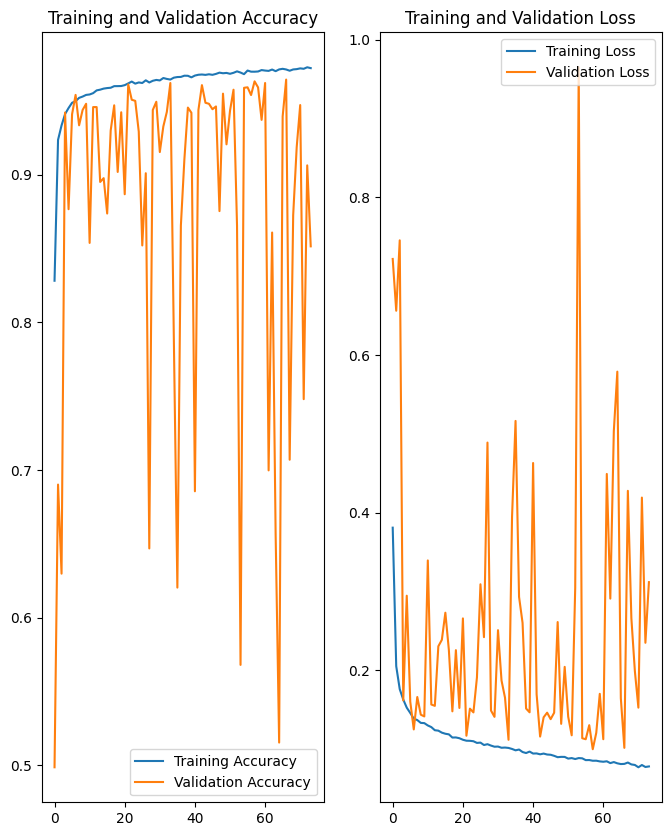

In [9]:
acc= face_fit.history['accuracy']
val_acc = face_fit.history['val_accuracy']

loss = face_fit.history['loss']
val_loss = face_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(0,74)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [10]:
print(str('Top Training Accuracy: ') + str(round(max(acc),4)))
print(str('Top Validation Accuracy: ') + str(round(max(val_acc),4)))

Top Training Accuracy: 0.9728
Top Validation Accuracy: 0.9645


In [11]:
model.save('GC weights/Unfrozen/mod2a-gs/mod2a_gs.h5')